<a href="https://colab.research.google.com/github/djy2211/Project4/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#kaggle.json
import json
import os

json_file_path = '/content/kaggle.json'
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

os.environ['KAGGLE_USERNAME'] = data['username']
os.environ['KAGGLE_KEY'] = data['key']

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:33<00:00, 136MB/s]
100% 3.10G/3.10G [00:33<00:00, 99.6MB/s]


In [ ]:
!unzip -qq "/content/breast-histopathology-images.zip"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.utils as image
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random

In [ ]:
breast_img = glob.glob('/content/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/content/12880/1/12880_idx5_x401_y1451_class1.png
/content/12880/1/12880_idx5_x1251_y751_class1.png
/content/12880/1/12880_idx5_x801_y951_class1.png


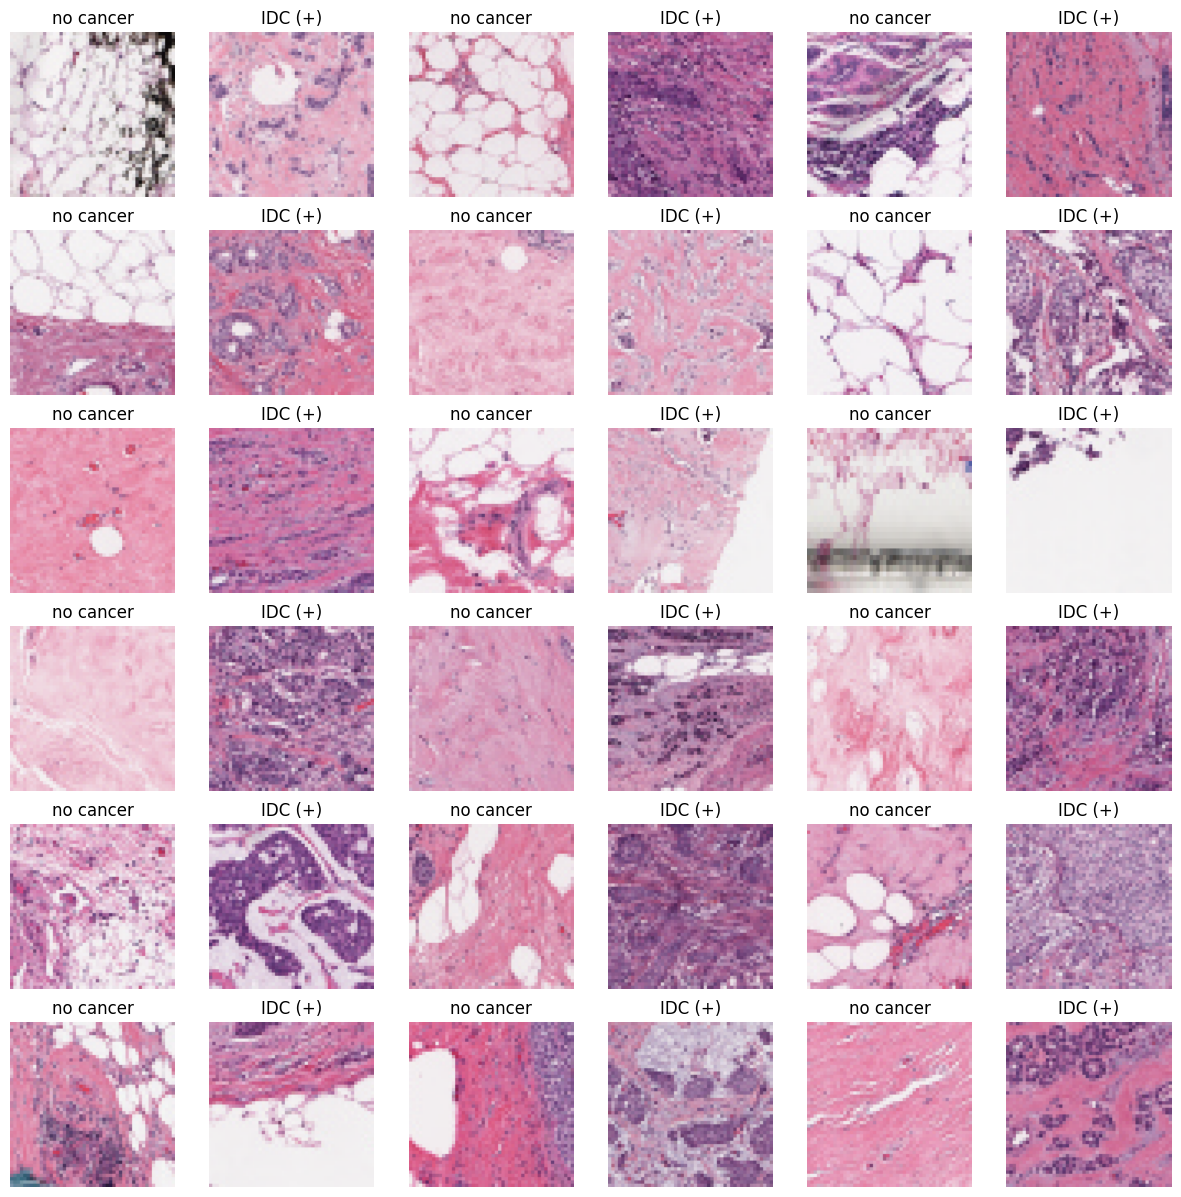

In [ ]:
# 양성 음성 사진 확인(N_IDC = 암 아님,P_IDC = 유방암(양성) )
N_IDC = []
P_IDC = []

# 이미지 이름이 뒤에서 5번째 문자열 확인하여 양성과 음성을 나눔
for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)

    elif img[-5] == '1' :
        P_IDC.append(img)

plt.figure(figsize = (15, 15))

#클래스에서 무작위 이미지 선택을 위해 임의의 정수를 생성
some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

#시각화
s = 0
for num in some_non:

        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [ ]:
#데이터 셋 설정
NewN_IDC=N_IDC[:78786]
P_IDC = P_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


In [ ]:
#openCV 활용 이미지 사이즈 조정
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:

    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [ ]:
#데이터 셋 크기 확인.
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr))

78786
78786
157572


In [ ]:
#이미지,클래스 생성
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr[:20000], can_img_arr[:20000]))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
#NumPy 배열로 변환
X = np.array(X)
y = np.array(y)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# 다중 클래스 분류 문제를 학습하는 데 용이하게 원-핫 인코딩 사용
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

print( X_train.shape)
print( X_test.shape)

(28000, 50, 50, 3)
(12000, 50, 50, 3)


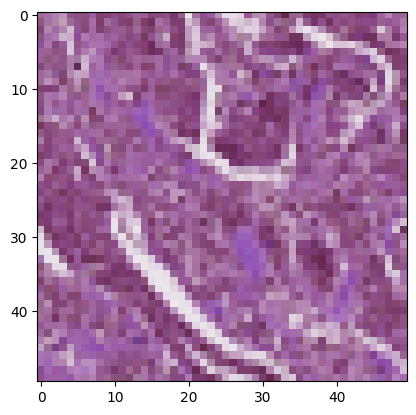

In [ ]:
#트레인 이미지 확인
plt.imshow(X_train[0])

In [ ]:
#모델링 변수 임포트
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
#모델링 선언
early_stop=EarlyStopping(monitor='val_loss',patience=5) #조기종료, 과적합 방지.
model = Sequential()#모델링
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [ ]:
#모델링 compile
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                        

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 25, batch_size = 35)

Epoch 1/25
196/800 [======>.......................] - ETA: 8:04 - loss: 0.4724 - accuracy: 0.8229

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test,y_test)

375/375 [==============================] - 3s 7ms/step - loss: 0.2132 - accuracy: 0.9373


[0.21323539316654205, 0.937333345413208]

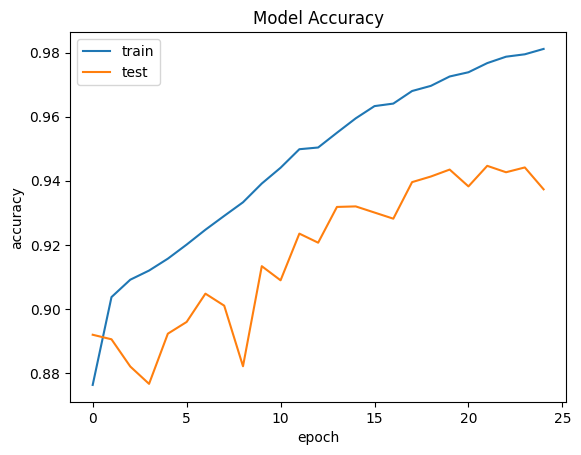

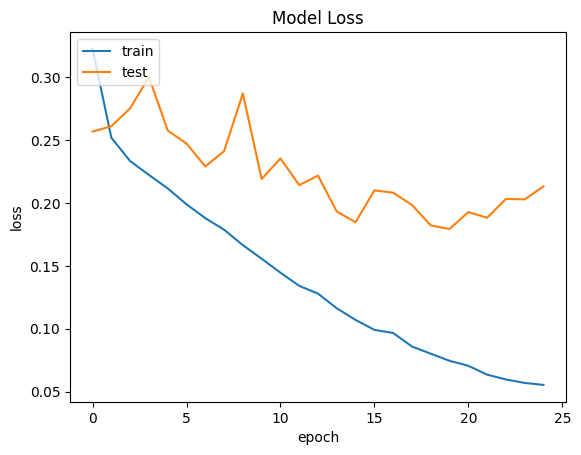

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

375/375 [==============================] - 2s 4ms/step


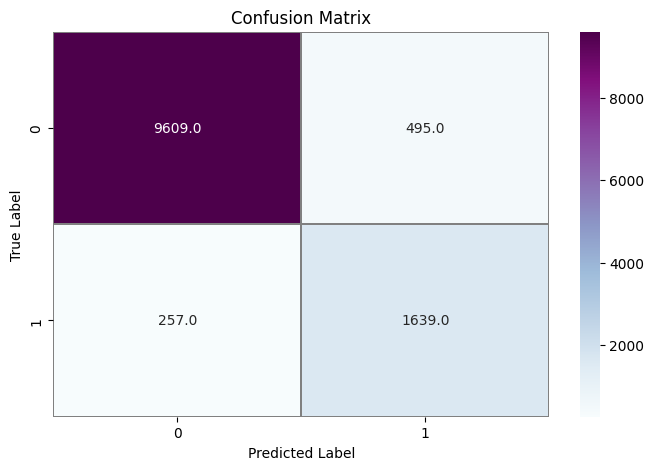

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test,axis = 1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

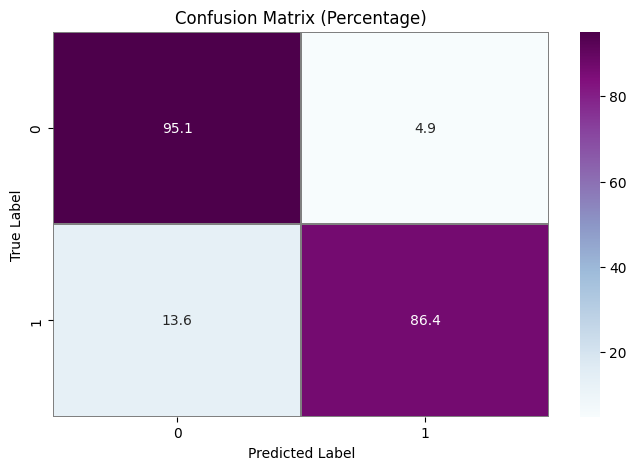

In [ ]:
# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

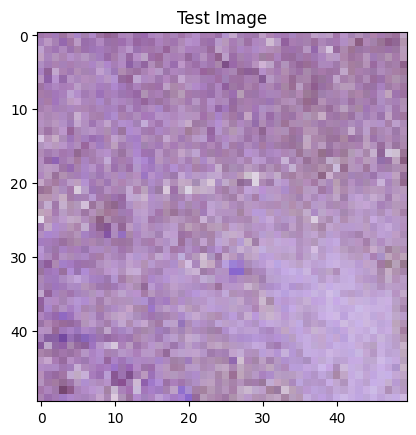

In [ ]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

index = 8000
img_plot(X_test, index)

In [ ]:
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

1/1 [==============================] - 0s 40ms/step
Predicted Value using  cnn model 1
True Value 1


In [ ]:
model.save("/content/Brest CNN dectect.h5")